# 打开股票量化的黑箱(自己动手实现一个印钞机) 第七章
### 作者：阿布🐶

### 未经本人允许禁止转载

##  非均衡胜负收益带来的必然非均衡胜负比例，目标由因子的能力解决一部分，模式识别提升关键的一部分

In [35]:
import ZEnv
import ZLog
import ZCommonUtil
import pandas as pd
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = 100
%matplotlib inline

上一章构造了 3个主裁和一个辅助裁判，这一章开始构建边裁及裁判的最优参数选择

In [36]:
fn = ZEnv.g_project_root + '/data/cache/orders_pd_ump_hit_predict_abu'
key = 'orders_pd_ump_hit_predict_abu'
orders_pd_ump = ZCommonUtil.load_hdf5(fn, key)
orders_pd_ump.shape

(47374, 39)

**UmpEdge 边裁**

In [37]:
import UmpEdge

In [38]:
ump_edge = UmpEdge.UmpEdgeClass(orders_pd_ump)

**边裁使用profit， profit_cg作为gmm分类数据生成ss分类序列，之后根据profit_cg进行rank数据生成p_rk_cg，再找到top winN，top lossN N现在的设置是25%且对外不暴露，分别给于1， -1, 其它的都是0生成rk列，将atr，deg，wave所有数据的numpy矩阵保存起来，对输入的数据进行标准化后实行距离对比，找到最匹配的
rk标签**


### 简单说就是引入交易后置参数收益，把收益的top 25%单子，和blow 25%的单子的特征抽取，但是由于
### 在实际交易那一时刻没有收益这个变量，所以无法直接预测，所以之前将特征的x预处理做标准化，再使
### pairwise_distances计算输入的相似度最相似那个预存x，影射出那个x是否在top25%或者below25%, 明白了吗？
### 不明白就看源代码吧，下面也贴了一段

核心代码如下所示，或者直接查阅源代码UmpEdge.py

In [6]:
    def dump_clf(self):
        dump_clf = {'top_loss_ss': self.top_loss_ss, 'top_win_ss': self.top_win_ss,
                    'fiter_df': self.fiter.df, 'fiter_x': self.fiter.x}

        ZCommonUtil.dump_pickle(dump_clf, self.dump_file_fn())

    def predict(self, **kwargs):

        dump_clf = UmpEdgeClass.dump_clf_manager.get_ump(self)

        x = np.array([kwargs[col] for col in dump_clf['fiter_df'].columns[2:-3]])

        x = x.reshape(1, -1)
        con_x = np.concatenate((x, dump_clf['fiter_x']), axis=0)

        x_scale_param = self.scaler.fit(con_x)
        con_x = self.scaler.fit_transform(con_x, x_scale_param)

        distance_min_ind = pairwise_distances(con_x[0].reshape(1, -1), con_x[1:],
                                              metric='euclidean').argmin()
        '''
            置换出可以作为分类输入的x
        '''
        ss = dump_clf['fiter_df'].iloc[distance_min_ind]['ss']
        if ss in dump_clf['top_loss_ss']:
            return -1
        elif ss in dump_clf['top_win_ss']:
            return 1
        return 0

    def gmm_component_filter(self, nc=20, threshold=0.72, show=True):
        clf = GMM(nc, n_iter=500, random_state=3).fit(self.fiter.y)
        ss = clf.predict(self.fiter.y)

        self.fiter.df['p_rk_cg'] = self.fiter.df['profit_cg'].rank()
        self.fiter.df['ss'] = ss

        win_top = len(self.fiter.df['profit_cg']) - len(self.fiter.df['profit_cg']) * 0.25
        loss_top = len(self.fiter.df['profit_cg']) * 0.25
        self.fiter.df['rk'] = 0
        self.fiter.df['rk'] = np.where(self.fiter.df['p_rk_cg'] > win_top, 1, self.fiter.df['rk'])
        self.fiter.df['rk'] = np.where(self.fiter.df['p_rk_cg'] < loss_top, -1, self.fiter.df['rk'])

        xt = pd.crosstab(self.fiter.df['ss'], self.fiter.df['rk'])
        xt_pct = xt.div(xt.sum(1).astype(float), axis=0)

        if show:
            xt_pct.plot(
                figsize=(16, 8),
                kind='bar',
                stacked=True,
                title=str('ss') + ' -> ' + str('result'))
            plt.xlabel(str('ss'))
            plt.ylabel(str('result'))

            ZLog.info(xt_pct[xt_pct[-1] > threshold])
            ZLog.info(xt_pct[xt_pct[1] > threshold])

        self.top_loss_ss = xt_pct[xt_pct[-1] > threshold].index
        self.top_win_ss = xt_pct[xt_pct[1] > threshold].index
        return xt, xt_pct


In [39]:
ump_edge.fiter.df.head()

,profit,profit_cg,atr_std,deg_hisWindowPd,deg_windowPd,deg_60WindowPd,wave_score1,wave_score2,wave_score3
2015-07-28,21051.90,0.105290,0.045208,-1.256691,3.895622,5.363046,0.116619,-0.122372,-0.222840
2015-07-28,-8411.46,-0.043313,0.234763,15.908454,4.108007,4.199374,0.646118,0.731843,0.662114
2015-07-28,-19158.06,-0.095806,-0.408504,21.175689,3.394158,7.384808,0.050669,-0.131306,-0.158877
2015-07-28,-5845.79,-0.074492,0.687850,-7.023154,-0.075254,5.413456,0.671606,0.799534,0.829494
2015-07-28,12345.00,0.061728,0.011969,11.519025,3.621430,5.765467,-0.149591,-0.227755,-0.259943


### 如下可视化是不是更明白点了，top 25是1， below 25是－1，其它的都用0代表，gmm分类之后rank profit，大于阀值的类别得到保留，这些类别如下所示

rk   -1    0    1
ss               
0   1.0  0.0  0.0
6   1.0  0.0  0.0
7   1.0  0.0  0.0
9   1.0  0.0  0.0
19  1.0  0.0  0.0
rk   -1         0         1
ss                         
2   0.0  0.000000  1.000000
4   0.0  0.000000  1.000000
5   0.0  0.000000  1.000000
10  0.0  0.000000  1.000000
11  0.0  0.000000  1.000000
12  0.0  0.028401  0.971599
13  0.0  0.000000  1.000000
16  0.0  0.000000  1.000000
18  0.0  0.000000  1.000000


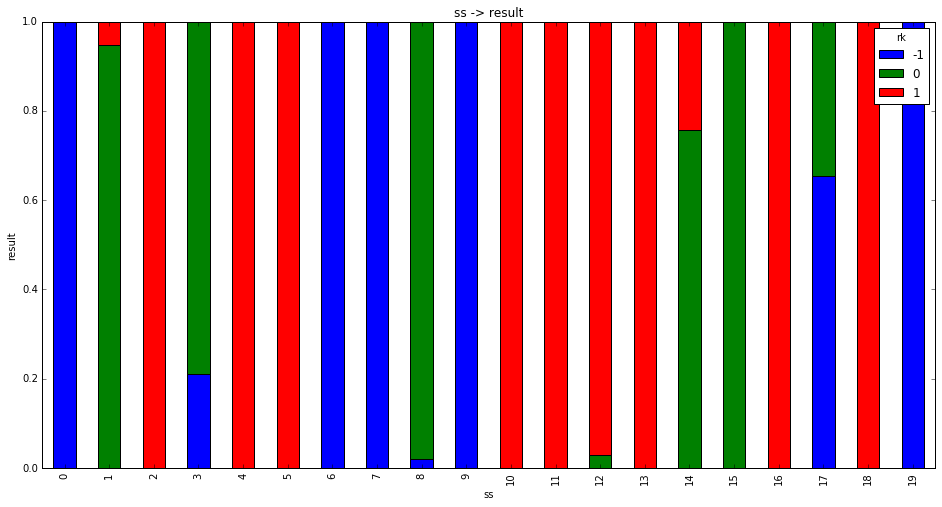

In [40]:
xt, xt_pct = ump_edge.gmm_component_filter(nc=20, threshold=0.72, show=True)

### pd.crosstab交织表生成gmm生成的类别与rk的交织结果

In [41]:
xt

rk,-1,0,1
ss,,,
0,2465,0,0
1,0,4326,241
2,0,0,4
3,1073,4038,0
4,0,0,3053
5,0,0,33
6,47,0,0
7,3633,0,0
8,103,4799,0


In [42]:
xt_pct

rk,-1,0,1
ss,,,
0,1.000000,0.000000,0.000000
1,0.000000,0.947230,0.052770
2,0.000000,0.000000,1.000000
3,0.209939,0.790061,0.000000
4,0.000000,0.000000,1.000000
5,0.000000,0.000000,1.000000
6,1.000000,0.000000,0.000000
7,1.000000,0.000000,0.000000
8,0.021012,0.978988,0.000000


### 最后的常规任务就是将裁判本地序列话

In [ ]:
ump_edge.dump_clf()

_____

## **寻找裁判最优参数**

### 将orders_pd_ump数据重新读取，新的数据包涵了使用这些裁判进行裁决，但不拦截的所有统计数据，形式如下所示

### 通过数据统计来组织拦截规则，比如几个主裁一起合作，达到几个hit就直接拦截，
### 几个等待边裁裁决，辅助裁判应用赋予的权力权重，这些参数设置好了之后就可以组成
## 一个实用的交易拦截系统

In [60]:
orders_pd_ump.filter(regex='result|ump_main_mlfiter*|ind_key').tail(2)

,result,ump_main_mlfitermainpdclass_predict,ump_main_mlfiterdegpdclass_predict,ump_main_mlfiterwavepdclass_predict,ump_main_mlfitermainpdclass_hit,ump_main_mlfiterdegpdclass_hit,ump_main_mlfiterwavepdclass_hit
2012-07-12,1,True,True,True,0,0,0
2012-07-16,-1,True,True,True,0,0,0


In [62]:
# 先对三个主裁寻找参数，主裁的优先级是一致的，至少这里是这样实现的

from MlFiter import MlFiterClass

orders_pd_ump['ind_key'] = np.arange(0, len(orders_pd_ump))
orders_pd_tmp = orders_pd_ump.filter(regex='result|ump_main_mlfiter*|ind_key')
order_has_ret = orders_pd_tmp[orders_pd_tmp['result'] <> 0]
order_has_ret['result'] = np.where(order_has_ret['result'] == -1, 0, 1)

order_has_ret['ump_main_mlfitermainpdclass_predict'] = np.where(order_has_ret['ump_main_mlfitermainpdclass_predict'] == True, 1, 0)
order_has_ret['ump_main_mlfiterdegpdclass_predict'] = np.where(order_has_ret['ump_main_mlfiterdegpdclass_predict'] == True, 1, 0)
order_has_ret['ump_main_mlfiterwavepdclass_predict'] = np.where(order_has_ret['ump_main_mlfiterwavepdclass_predict'] == True, 1, 0)

order_has_ret = order_has_ret[(order_has_ret['ump_main_mlfitermainpdclass_predict'] == 0) | 
                              (order_has_ret['ump_main_mlfiterdegpdclass_predict'] == 0) | 
                              (order_has_ret['ump_main_mlfiterwavepdclass_predict'] == 0)]

order_has_ret['predict_sum'] = order_has_ret['ump_main_mlfitermainpdclass_predict'] + order_has_ret['ump_main_mlfiterdegpdclass_predict'] + \
            order_has_ret['ump_main_mlfiterwavepdclass_predict']

order_has_ret['hit_sum'] = order_has_ret['ump_main_mlfiterdegpdclass_hit'] + order_has_ret['ump_main_mlfitermainpdclass_hit'] + \
            order_has_ret['ump_main_mlfiterdegpdclass_hit']
    
matrix = order_has_ret.as_matrix()
y = matrix[:, 0]
x = matrix[:, 1:]
fiter = MlFiterClass(x, y, order_has_ret)
fiter.df.head()
order_has_ret.head()

,result,ump_main_mlfitermainpdclass_predict,ump_main_mlfiterdegpdclass_predict,ump_main_mlfiterwavepdclass_predict,ump_main_mlfitermainpdclass_hit,ump_main_mlfiterdegpdclass_hit,ump_main_mlfiterwavepdclass_hit,ind_key,predict_sum,hit_sum
2015-07-28,0,0,1,1,7,0,0,523,2,7
2015-07-28,0,1,0,1,0,25,0,524,2,50
2015-07-28,0,1,1,0,0,0,1,540,2,0
2015-07-28,0,0,1,1,3,0,0,547,2,3
2015-07-28,0,0,1,1,1,0,0,549,2,1


In [63]:
order_has_ret.T

,2015-07-28 00:00:00,2015-07-28 00:00:00,2015-07-28 00:00:00,2015-07-28 00:00:00,2015-07-28 00:00:00,2015-07-28 00:00:00,2015-07-28 00:00:00,2015-07-28 00:00:00,2015-07-29 00:00:00,2015-07-29 00:00:00,2015-07-30 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-08-03 00:00:00,2015-08-03 00:00:00,2015-08-07 00:00:00,2015-08-07 00:00:00,2015-08-07 00:00:00,2015-08-10 00:00:00,2015-08-10 00:00:00,2015-08-10 00:00:00,2015-08-11 00:00:00,2015-08-12 00:00:00,2015-08-21 00:00:00,2015-08-25 00:00:00,2015-08-25 00:00:00,2015-08-25 00:00:00,2015-08-25 00:00:00,2015-08-26 00:00:00,2015-08-27 00:00:00,2015-08-27 00:00:00,2015-08-27 00:00:00,2015-08-27 00:00:00,2015-08-27 00:00:00,2015-08-27 00:00:00,2015-08-27 00:00:00,2015-08-27 00:00:00,2015-08-27 00:00:00,2015-08-27 00:00:00,2015-08-28 00:00:00,2015-08-28 00:00:00,2015-08-28 00:00:00,2015-08-28 00:00:00,2015-08-28 00:00:00,2015-08-28 00:00:00,2015-08-28 00:00:00,2015-08-28 00:00:00,2015-08-31 00:00:00,2015-08-31 00:00:00,...,2012-04-11 00:00:00,2012-04-11 00:00:00,2012-04-11 00:00:00,2012-04-12 00:00:00,2012-04-12 00:00:00,2012-04-13 00:00:00,2012-04-16 00:00:00,2012-04-19 00:00:00,2012-04-20 00:00:00,2012-04-24 00:00:00,2012-04-24 00:00:00,2012-04-26 00:00:00,2012-04-27 00:00:00,2012-05-01 00:00:00,2012-05-03 00:00:00,2012-05-04 00:00:00,2012-05-07 00:00:00,2012-05-07 00:00:00,2012-05-08 00:00:00,2012-05-09 00:00:00,2012-05-10 00:00:00,2012-05-15 00:00:00,2012-05-15 00:00:00,2012-05-15 00:00:00,2012-05-18 00:00:00,2012-05-18 00:00:00,2012-05-21 00:00:00,2012-05-25 00:00:00,2012-05-25 00:00:00,2012-05-30 00:00:00,2012-06-01 00:00:00,2012-06-05 00:00:00,2012-06-06 00:00:00,2012-06-06 00:00:00,2012-06-07 00:00:00,2012-06-07 00:00:00,2012-06-07 00:00:00,2012-06-08 00:00:00,2012-06-11 00:00:00,2012-06-11 00:00:00,2012-06-14 00:00:00,2012-06-18 00:00:00,2012-06-18 00:00:00,2012-06-19 00:00:00,2012-06-20 00:00:00,2012-06-22 00:00:00,2012-06-28 00:00:00,2012-06-29 00:00:00,2012-07-03 00:00:00,2012-07-09 00:00:00
result,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,...,0,0,1,1,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,1,1,0,1,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0
ump_main_mlfitermainpdclass_predict,0,1,1,0,0,0,1,1,1,1,1,1,1,0,1,1,1,0,1,1,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,...,1,1,1,0,1,1,0,0,1,1,1,1,1,1,1,1,0,1,1,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,1,1,0,0,1,1,1
ump_main_mlfiterdegpdclass_predict,1,0,1,1,1,1,1,1,0,0,0,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,1,1,1,0,1,0,1,0,1,0,1,1,0,0,0,...,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,0,1,1,1,1,0,0,1,1,0,1,1,1,0,1,0,1,0,1,0,0,0,1,1,0,1,1,0,0,0,1,1,1,0,0
ump_main_mlfiterwavepdclass_predict,1,1,0,1,1,1,0,0,1,1,1,0,0,1,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,1,1,0,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,1,1,0,1,0,0,0,1,0,1,0,1,0,1,1,1,0,1,1,1,0,1,1,1,1,1,0,1,1
ump_main_mlfitermainpdclass_hit,7,0,0,3,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,4,0,0,14,0,1,1,0,1,1,0,11,1,24,24,1,0,25,24,0,0,16,9,0,1,7,0,11,23,...,0,0,0,1,0,0,1,6,0,0,0,0,0,0,0,0,1,0,0,1,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,16,0,0,1,1,0,0,0
ump_main_mlfiterdegpdclass_hit,0,25,0,0,0,0,0,0,2,24,7,0,0,0,1,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,1,5,0,8,0,0,0,7,0,3,0,7,0,3,0,0,1,7,5,...,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,1,0,4,24,2,0,0,6,0,0,7,2,2,0,0,0,5,1
ump_main_mlfiterwavepdclass_hit,0,0,1,0,0,0,2,1,0,0,0,1,7,0,0,8,7,0,4,0,54,0,1,1,0,10,7,34,7,0,0,0,0,20,0,7,0,7,0,0,0,21,0,4,0,0,54,0,1,6,...,3,2,3,0,3,1,7,7,2,0,1,1,1,1,1,0,55,1,49,0,0,0,0,10,0,2,1,1,0,1,0,1,0,7,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
ind_key,523,524,540,547,549,572,582,643,691,735,800,815,816,827,845,847,943,944,952,983,985,989,1009,1022,1108,1132,1137,1146,1154,1163,1191,1198,1202,1205,1208,1213,1218,1221,1222,1227,1230,1232,1244,1245,1258,1269,1273,1274,1279,1282,...,45977,45982,46005,46010,46023,46030,46047,46109,46134,46180,46220,46264,46266,46292,46337,46350,

通过可视化寻找参数，综合参考数量，概率等多方面因素

**如下图所示，1个hit以上就上0.65了 20个hit 0.70以上，> 20个就可以主裁直接使用裁决了，小于的等待，辅助裁判，边裁**

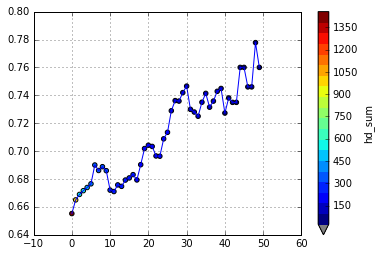

In [21]:
from sklearn import metrics
import matplotlib.pyplot as plt

hd_range = np.arange(0, 50)
hd_result = []
hd_sum = []
for hd in hd_range:
    xt = order_has_ret[(order_has_ret['hit_sum'] > hd)]['result'].value_counts()
    hs = xt.sum()
    hd_sum.append(hs)
    hd_result.append(float(xt[0])/hs)
    
cmap = plt.get_cmap('jet', 20)
cmap.set_under('gray')
fig, ax = plt.subplots()
ax.plot(hd_range, hd_result)
cax = ax.scatter(hd_range, hd_result, c=hd_sum, cmap=cmap, vmin=np.min(hd_sum),
                 vmax=np.max(hd_sum))
ax.grid(True)
fig.colorbar(cax, label='hd_sum', extend='min')

**跳空的辅助裁判本身数据就少，辅助裁判尽量裁决 jump ump可以使用hit 5作为阀值，大于5个hit直接裁决，否则等待边裁**

[ 0  1  2  3  4  7  8 15 18]


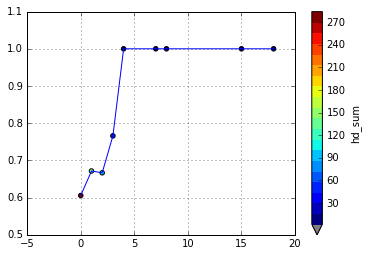

In [24]:
orders_pd_tmp = orders_pd_ump.filter(regex='result|ump_jump_mlfiter|ind_key*')
order_has_ret = orders_pd_tmp[orders_pd_tmp['result'] <> 0]
order_has_ret['result'] = np.where(order_has_ret['result'] == -1, 0, 1)
order_has_ret['ump_jump_mlfiterjumppdclass_predict'] = np.where(order_has_ret['ump_jump_mlfiterjumppdclass_predict'] == True, 1, 0)

order_has_ret = order_has_ret[(order_has_ret['ump_jump_mlfiterjumppdclass_predict'] == 0)]

hd_range = np.unique(order_has_ret['ump_jump_mlfiterjumppdclass_hit'])[:-1]
# -1 要使用0开始的范围
hd_range = np.array(hd_range) - 1
print hd_range
hd_result = []
hd_sum = []
for hd in hd_range:
    xt = order_has_ret[order_has_ret['ump_jump_mlfiterjumppdclass_hit'] > hd]['result'].value_counts()
    hs = xt.sum()
    hd_sum.append(hs)
    hd_result.append(float(xt[0])/hs)
    
cmap = plt.get_cmap('jet', 20)
cmap.set_under('gray')
fig, ax = plt.subplots()
ax.plot(hd_range, hd_result)
cax = ax.scatter(hd_range, hd_result, c=hd_sum, cmap=cmap, vmin=np.min(hd_sum),
                 vmax=np.max(hd_sum))
ax.grid(True)
fig.colorbar(cax, label='hd_sum', extend='min')

边裁在现在的规则中不需要需找参数

In [30]:
jump_hit_pd = order_has_ret[order_has_ret['ump_jump_mlfiterjumppdclass_hit'] < 3]
jump_hit_pd_org = orders_pd_ump.iloc[jump_hit_pd['ind_key']]

In [31]:
def apply_judge(order):
    return ump_edge.predict(atr_std=order.atr_std, deg_hisWindowPd=order.deg_hisWindowPd, deg_windowPd=order.deg_windowPd,
                 deg_60WindowPd=order.deg_60WindowPd, wave_score1=order.wave_score1, wave_score2=order.wave_score2,
                 wave_score3=order.wave_score3)
jump_hit_pd['edge'] = jump_hit_pd_org.apply(apply_judge, axis=1)
jump_hit_pd['edge'].value_counts()

 0    144
-1     32
 1     18
Name: edge, dtype: int64

好了，这些都组织好之后，下一章就该看看这个系统能不能成为印钞机之路上那个重要组成环节了，下一章也是最终章节，如果您
真的能看到这里，并且大概知道我再说些什么，我就感觉很欣慰了，如果那样的话多多交流

## 感谢🙏您能有耐心看到这里
## 如果有什么问题可以加阿布的微信 
## 微信号：aaaabbbuu

![image](./mmexport1475383814280.jpg)